# 이미지에서 특징 감지하기

## 합성곱 신경망 만들기

In [1]:
import tensorflow as tf

### 케라스 ImageDataGenerator

In [2]:
import urllib.request
import zipfile

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

flow_from_directory(directory, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None, interpolation='nearest')

In [4]:
from tensorflow.keras.optimizers import RMSprop

#### `image_dataset_from_directory` 사용하기

- 기본 파라미터
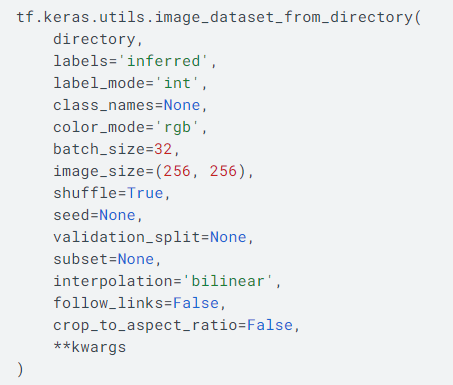

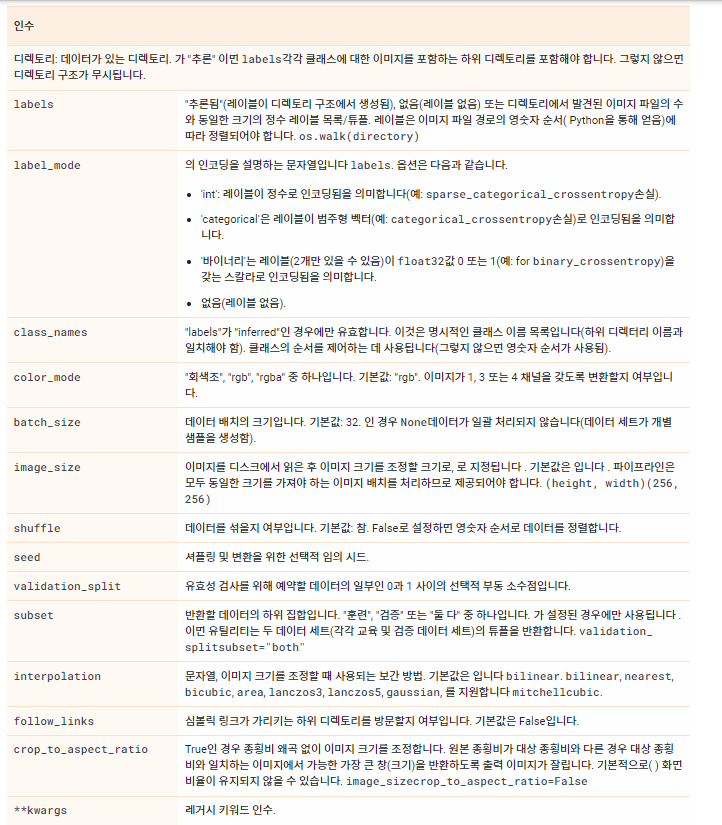

## 다중 분류

### 데이터 다운 받기

In [5]:
# os가 리눅스일때 다운받는 패키지-파이썬 내부패키지는 윈도우에서도 적용가능
!pip install wget 

- mac : (wget 없다는 에러가 발생하면)
    - brew install wget (home brew가 있는 경우)
    - curl 설치
        - https://ftp.gnu.org/gnu/wget/ 에서 파일 다운로드 후 다운 폴더로 가서
        - $ curl -O https://ftp.gnu.org/gnu/wget/wget-1.19.5.tar.gz
        - $ tar xvf wget-1.19.5.tar.gz
        - $ cd wget-1.19.5/
        - $ ./configure --with-ssl=openssl
        - $ make
        - $ make install

In [6]:
import wget

- 윈도우 환경

In [7]:
url = "https://storage.googleapis.com/learning-datasets/rps.zip"
wget.download(url)

'rps (2).zip'

In [8]:
url = "https://storage.googleapis.com/learning-datasets/rps-test-set.zip"
wget.download(url)

'rps-test-set (2).zip'

- 리눅스 환경

In [9]:
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/rps.zip \
    -O ./rps.zip

--2023-09-12 02:47:06--  https://storage.googleapis.com/learning-datasets/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.206.251, 172.217.161.251, 142.250.206.219, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.206.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘./rps.zip’

./rps.zip           100%[===================>] 191.38M  36.2MB/s    in 6.1s    

2023-09-12 02:47:13 (31.5 MB/s) - ‘./rps.zip’ saved [200682221/200682221]



In [10]:
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/rps-test-set.zip \
    -O ./rps-test-set.zip

--2023-09-12 02:47:13--  https://storage.googleapis.com/learning-datasets/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.206.251, 172.217.161.251, 142.250.206.219, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.206.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘./rps-test-set.zip’

./rps-test-set.zip  100%[===================>]  28.15M  18.0MB/s    in 1.6s    

2023-09-12 02:47:15 (18.0 MB/s) - ‘./rps-test-set.zip’ saved [29516758/29516758]



- 데이터 압축 풀기

In [11]:
import zipfile
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image

In [12]:
local_zip = './rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

- 학습데이터 전처리및 데이터 증식

In [13]:
TRAINING_DIR = "./rps/"
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

- 검증데이터 준비 및 전처리

### 이미지 파일을 split 해주는 패키지
- !pip install split-folders
- !pip install split-folders[full] 
    - progress bar를 보고 싶을때

In [14]:
!pip install split-folders[full]

In [15]:
local_zip = './rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

In [16]:
import splitfolders

test_set_dir = "./rps-test-set" # val 폴더 데이터를 val/test로 분리
test_val_dir = './rps_test_val'

splitfolders.ratio(test_set_dir, output=test_val_dir,seed=1337,ratio=(0.8,0.2))

Copying files: 372 files [00:00, 5483.39 files/s]


# train/val/test 나누기

- ratio 파라미터에 원하는 (train, validation, test) 비율을 입력 ex) (0.8, 0.1, 0.1)
    - splitfolders.ratio("input_folder", output="output", seed=1337, ratio=(.8, .1, .1))
    
- train/val 나누기 : train을 val로 val을 test로 사용
    - test는 제외하고 train, validation만 나누고 싶다면 두 개의 인자만 입력 ex) (0.8, 0.1)

In [17]:
# split 코드 입력
VALIDATION_DIR = "./rps_test_val/train"
TEST_DIR = "./rps_test_val/val"

### 이미지 전처리

In [18]:
# 이미지 증식 generator 생성
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [19]:
# train_datagen generaotr로 train_val_test 이미지 증식
# 학습데이터만 증식해도 무방 함
train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150,150),
    class_mode='categorical'
)

validation_generator = train_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150,150),
    class_mode='categorical'
)

test_generator = train_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150,150),
    class_mode='categorical'
)

Found 2520 images belonging to 3 classes.
Found 297 images belonging to 3 classes.
Found 75 images belonging to 3 classes.


## 모델 생성

In [20]:
# 앞에서 사용했던 기본 모델 사용
model = tf.keras.models.Sequential([
    # 입력 크기는 원하는 이미지(150x150, 3채널)와 맞아야 합니다.
    # 첫 번째 합성곱 층
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', 
                           input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # 두 번째 합성곱 층
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # 세 번째 합성곱 층
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # 네 번째 합성곱 층
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # 밀집 층에 전달하가 위해 펼칩니다.
    tf.keras.layers.Flatten(),
    # 512개 뉴런을 가진 은닉층
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
    # 출력층(다중분류이므로 softmax)
])

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
              metrics=['accuracy'])

In [22]:
model.fit(train_generator, 
          epochs=25, 
          validation_data=validation_generator)

Epoch 1/25
79/79 [==============================] - 24s 255ms/step - loss: 1.1554 - accuracy: 0.3540 - val_loss: 1.0735 - val_accuracy: 0.4343
Epoch 2/25
79/79 [==============================] - 19s 238ms/step - loss: 0.9529 - accuracy: 0.5429 - val_loss: 0.6419 - val_accuracy: 0.7306
Epoch 3/25
79/79 [==============================] - 19s 237ms/step - loss: 0.6624 - accuracy: 0.7167 - val_loss: 0.6733 - val_accuracy: 0.7407
Epoch 4/25
79/79 [==============================] - 19s 237ms/step - loss: 0.4074 - accuracy: 0.8357 - val_loss: 0.6525 - val_accuracy: 0.7205
Epoch 5/25
79/79 [==============================] - 20s 247ms/step - loss: 0.2845 - accuracy: 0.8933 - val_loss: 0.3357 - val_accuracy: 0.8687
Epoch 6/25
79/79 [==============================] - 18s 232ms/step - loss: 0.2249 - accuracy: 0.9210 - val_loss: 0.2031 - val_accuracy: 0.9158
Epoch 7/25
79/79 [==============================] - 18s 232ms/step - loss: 0.1498 - accuracy: 0.9520 - val_loss: 0.1723 - val_accuracy: 0.9360

- val_loss: 0.3668 - val_accuracy: 0.9125
    - 이전 훈련에 더 좋은 loss 점수가 보임
- chk point 및 early stopping 사용할 필요가 있어보임

In [23]:
# 테스트 data 검증
model.evaluate(test_generator)

3/3 [==============================] - 1s 266ms/step - loss: 0.1855 - accuracy: 0.9467


[0.18553495407104492, 0.9466666579246521]

### test data 검증결과
- [0.3739057779312134, 0.8933333158493042]
- 학습 데이터와 test 데이터가 차이가 있음(더 학습할 여지가 있음)

In [24]:
# 조기 종료 및 chk pint 코드
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('best-model.h5')
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model.fit(train_generator, epochs=20, verbose=0, 
                    validation_data=validation_generator,
                    callbacks=[checkpoint_cb, early_stopping_cb])

In [25]:
history.history['loss']
# history.history['val_loss']

[0.036531832069158554,
 0.04512433707714081,
 0.03776368126273155,
 0.037541236728429794,
 0.0526103600859642,
 0.04573734849691391,
 0.033587753772735596,
 0.04060263931751251,
 0.030829966068267822]

- 예측 확인

In [26]:
import sys
sample_images = ['./image/rsp_image_{}.jpg'.format(i) for i in range(1,4)]

In [27]:
sample_images.append('./image/rsp_image_4.png')

In [28]:
sample_images

['./image/rsp_image_1.jpg',
 './image/rsp_image_2.jpg',
 './image/rsp_image_3.jpg',
 './image/rsp_image_4.png']

### np.expand_dims 함수
- numpy 패키지에서 제공하는 함수로, 배열의 차원을 확장
- 주로 딥러닝에서 다차원 배열을 다룰 때 사용되며, 특히 텐서의 차원을 조정할 때 자주 활용됨
- 문법
    - np.expand_dims(arr, axis)
        - arr: 차원을 확장할 배열
        - axis: 새로 추가될 차원의 위치. 이 값은 정수 또는 튜플 형태로 지정할 수 있음. 기본값은 0이며, 이는 첫 번째 차원(인덱스 0) 앞에 새로운 차원을 추가하겠다는 의미임

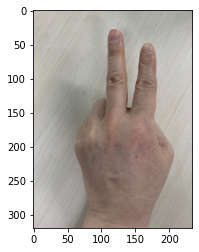

(150, 150, 3)
(1, 150, 150, 3)
1/1 [==============================] - 0s 232ms/step
./image/rsp_image_1.jpg는 가위입니다.


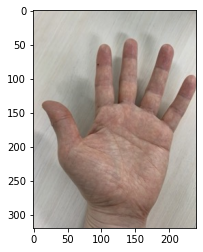

(150, 150, 3)
(1, 150, 150, 3)
1/1 [==============================] - 0s 21ms/step
./image/rsp_image_2.jpg는 보입니다.


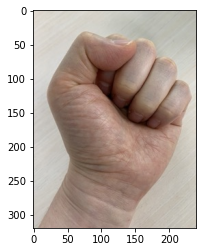

(150, 150, 3)
(1, 150, 150, 3)
1/1 [==============================] - 0s 21ms/step
./image/rsp_image_3.jpg는 바위입니다.


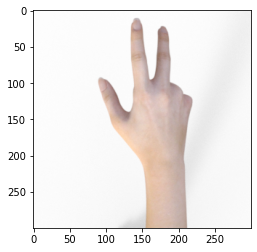

(150, 150, 3)
(1, 150, 150, 3)
1/1 [==============================] - 0s 20ms/step
./image/rsp_image_4.png는 가위입니다.


In [29]:
rsp_name = ['보', '바위', '가위']

for fn in sample_images:
    # 이미지 출력
    plt.imshow(mpimg.imread(fn))
    plt.show()
    
    # 이미지 불러오기
    img = tf.keras.utils.load_img(fn, target_size=(150,150))
    x = tf.keras.utils.img_to_array(img)
    print(x.shape)
    x = np.expand_dims(x, axis=0)
    print(x.shape)
    classes = model.predict(x)

    idx = np.argmax(classes[0])

    print(fn + "는 {}입니다.".format(rsp_name[idx]))

## 드롭아웃 규제
- 과대적합 방지
- 신경망층에서 dropout 추가 : drop 아웃층은 어디든 상관없음
- Improving neural networks by preventing co-adaptation of feature 논문에 따르면 dropout이 많은 모델일 수록 loss 증가를 막는 연구가 있음
    - 단 dropout은 너무 많으면 속도가 급격히 느려진다
        - 그러므로 많은 차이가 없으면 밀집신경망층 1개 정도에 추가하는 것이 일반적임

In [30]:
model = tf.keras.models.Sequential([
    # 입력 크기는 원하는 이미지(150x150, 3채널)와 맞아야 합니다.
    # 첫 번째 합성곱 층
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', 
                           input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # 두 번째 합성곱 층
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # 세 번째 합성곱 층
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # 네 번째 합성곱 층
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # 밀집 층에 전달하가 위해 펼칩니다.
    tf.keras.layers.Flatten(),
    # 512개 뉴런을 가진 은닉층
    tf.keras.layers.Dropout(0.5) ,
    tf.keras.layers.Dense(512, activation='relu'),  
#     tf.keras.layers.Dropout(0.3) ,
    tf.keras.layers.Dense(3, activation='softmax') # 출력층(다중분류이므로 softmax)
])

In [31]:
model.compile(loss='categorical_crossentropy',optimizer='rmsprop', 
              metrics=['accuracy'])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('best-model.h5')
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model.fit(train_generator, epochs=20, verbose=0, 
                    validation_data=validation_generator,
                    callbacks=[checkpoint_cb, early_stopping_cb])

In [32]:
model.evaluate(test_generator)

3/3 [==============================] - 1s 134ms/step - loss: 0.1373 - accuracy: 0.9600


[0.1373201608657837, 0.9599999785423279]

### dropout으로 단순화 결과
- 테스트 데이터의 확인은 DROPOUT 하지 않은 것보다 떨어짐

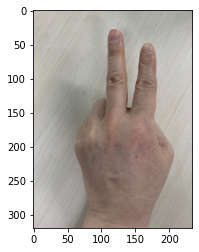

(150, 150, 3)
(1, 150, 150, 3)
1/1 [==============================] - 0s 75ms/step
./image/rsp_image_1.jpg는 가위입니다.


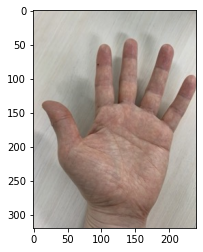

(150, 150, 3)
(1, 150, 150, 3)
1/1 [==============================] - 0s 21ms/step
./image/rsp_image_2.jpg는 보입니다.


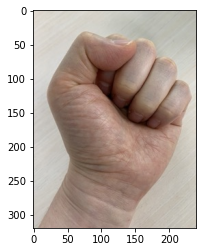

(150, 150, 3)
(1, 150, 150, 3)
1/1 [==============================] - 0s 21ms/step
./image/rsp_image_3.jpg는 바위입니다.


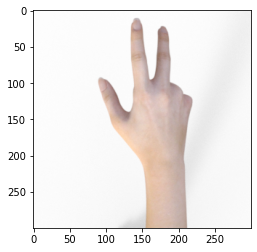

(150, 150, 3)
(1, 150, 150, 3)
1/1 [==============================] - 0s 20ms/step
./image/rsp_image_4.png는 가위입니다.


In [33]:
rsp_name = ['보', '바위', '가위']

for fn in sample_images:
    # 이미지 출력
    plt.imshow(mpimg.imread(fn))
    plt.show()
    
    # 이미지 불러오기
    img = tf.keras.utils.load_img(fn, target_size=(150, 150))
    x = tf.keras.utils.img_to_array(img)  # 학습시에는 generator가 실행했음
    print(x.shape)
    x = np.expand_dims(x, axis=0)  # 이미지는 3차원 입력은 4차원 배열이어야 함
    print(x.shape)

    classes = model.predict(x)

    idx = np.argmax(classes[0])
    print(fn + "는 {}입니다.".format(rsp_name[idx]))

- 실제 이미지로 테스트 했을때로 성능이 떨어짐
    - dropout 규제는 효과가 없다

In [34]:
import tensorflow as tf
# import tensorflow_datasets as tfds
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt

### 모델 재구성
- 패딩을 진행하고 노드수를 줄여서 진행 
- dropout을 추가
- opt 함수 변경
    - 효과적이지못함    

In [35]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu',
                              input_shape=(150, 150, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 37, 37, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 18, 18, 32)      

In [36]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

- label이 범주형이므로 'categorical_crossentropy'
- label이 정수형(1,2,3)이면 'sparse_categorical_crossentropy

In [37]:
model.fit(train_generator, 
          epochs=25, 
          validation_data=validation_generator)

Epoch 1/25
79/79 [==============================] - 21s 235ms/step - loss: 1.1055 - accuracy: 0.3865 - val_loss: 1.0040 - val_accuracy: 0.5623
Epoch 2/25
79/79 [==============================] - 18s 228ms/step - loss: 0.8018 - accuracy: 0.6349 - val_loss: 0.9751 - val_accuracy: 0.5219
Epoch 3/25
79/79 [==============================] - 18s 228ms/step - loss: 0.5437 - accuracy: 0.7813 - val_loss: 0.5350 - val_accuracy: 0.7273
Epoch 4/25
79/79 [==============================] - 18s 228ms/step - loss: 0.3912 - accuracy: 0.8409 - val_loss: 0.2347 - val_accuracy: 0.9057
Epoch 5/25
79/79 [==============================] - 18s 227ms/step - loss: 0.2703 - accuracy: 0.9052 - val_loss: 0.2975 - val_accuracy: 0.8788
Epoch 6/25
79/79 [==============================] - 18s 228ms/step - loss: 0.1844 - accuracy: 0.9373 - val_loss: 0.3502 - val_accuracy: 0.8721
Epoch 7/25
79/79 [==============================] - 18s 228ms/step - loss: 0.1715 - accuracy: 0.9413 - val_loss: 0.1306 - val_accuracy: 0.9529

In [38]:
model.evaluate(test_generator)

3/3 [==============================] - 1s 213ms/step - loss: 0.2239 - accuracy: 0.9067


[0.2239486426115036, 0.9066666960716248]

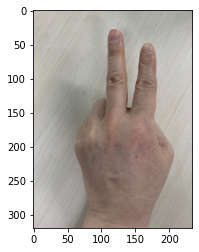

(150, 150, 3)
(1, 150, 150, 3)
1/1 [==============================] - 0s 154ms/step
[[1.000000e+00 1.690868e-11 0.000000e+00]]
./image/rsp_image_1.jpg는 보입니다.


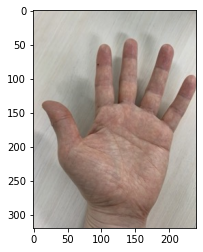

(150, 150, 3)
(1, 150, 150, 3)
1/1 [==============================] - 0s 20ms/step
[[1.000000e+00 2.705631e-29 0.000000e+00]]
./image/rsp_image_2.jpg는 보입니다.


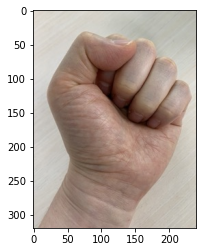

(150, 150, 3)
(1, 150, 150, 3)
1/1 [==============================] - 0s 20ms/step
[[0. 1. 0.]]
./image/rsp_image_3.jpg는 바위입니다.


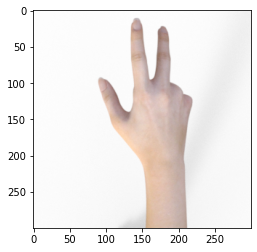

(150, 150, 3)
(1, 150, 150, 3)
1/1 [==============================] - 0s 20ms/step
[[0. 0. 1.]]
./image/rsp_image_4.png는 가위입니다.


In [39]:
rsp_name = ['보', '바위', '가위']

for fn in sample_images:
    # 이미지 출력
    plt.imshow(mpimg.imread(fn))
    plt.show()
    
    # 이미지 불러오기
    img = tf.keras.utils.load_img(fn, target_size=(150, 150))
    x = tf.keras.utils.img_to_array(img)  # 학습시에는 generator가 실행했음
    print(x.shape)
    x = np.expand_dims(x, axis=0)  # 이미지는 3차원 입력은 4차원 배열이어야 함
    print(x.shape)

    classes = model.predict(x)
    print(classes)
    idx = np.argmax(classes[0])
    print(fn + "는 {}입니다.".format(rsp_name[idx]))

## 층을 여려 경우로  구성해서 모델링을 진행하고 가장 좋은 성능평가나 혹은 테스트 결과의 모델을 사용
- 여기서 사용한 모델은 첫번째 모델이 가장 좋은 결과를 보임
    - 본인 결과로 정리
- 현재 실습은 딥러닝 돌리기에는 이미지 수가 작아보임